In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import pytorch_lightning as pl

In [8]:
from pathlib import Path
log_dir = Path('/data/drbelikov/ml_modulation/logs')

In [40]:
from torch.utils.data import Dataset, DataLoader

class ModulatorDataset(Dataset):
    def __init__(self, bit_count):
        self.bit_count = bit_count
        
    def __len__(self):
        return 2 ** self.bit_count
    
    def __getitem__(self, idx):
        result = torch.zeros(2 * self.bit_count)
        result[idx] = 1
        return result
    
dataset = ModulatorDataset(4)
dataloader = DataLoader(dataset, batch_size=4)

In [28]:
class ModulatorAutoencoder(pl.LightningModule):
    def __init__(self, class_count, encoding_shape):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(class_count, class_count),
            nn.ReLU(),
            nn.Linear(class_count, encoding_shape),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_shape, class_count),
            nn.ReLU(),
            nn.Linear(class_count, class_count),
            nn.Softmax()
        )
        self.loss_function = nn.CrossEntropyLoss()
        
    def forward(self, x):
        encoded = self.encoder(x)
        noise_shape = encoded.shape
        noise = torch.normal(torch.zeros(encoded.shape, device=self.device), 
                             torch.ones(encoded.shape, device=self.device))
        noised = encoded + noise
        return self.decoder(noised)
    
    def training_step(self, batch, batch_idx):
        decoded = self(batch)
        loss = self.loss_function(decoded, batch)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

In [41]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.progress import ProgressBar
import tqdm


class LitProgressBar(ProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm.tqdm(            
            disable=True,            
        )
        return bar


bar = LitProgressBar()
model = ModulatorAutoencoder(16, 2)
logger = CSVLogger(save_dir=log_dir)
trainer = pl.Trainer(max_epochs=5000, logger=logger, gpus=[0], callbacks=[bar])
trainer.fit(model, train_dataloader=dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name          | Type             | Params
---------------------------------------------------
0 | encoder       | Sequential       | 306   
1 | decoder       | Sequential       | 320   
2 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
626       Trainable params
0         Non-trainable params
626       Total params
0.003     Total estimated model params size (MB)


Epoch 0:   0%|                                            | 0/4 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x8 and 16x16)

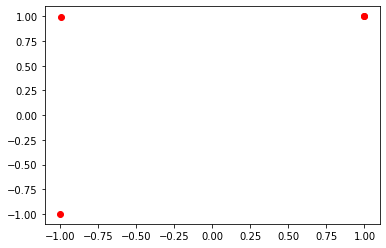

In [39]:
outputs = []
for batch in dataloader:
    cur_outputs = model.encoder(batch)
    outputs.append(cur_outputs.cpu().detach().numpy())
points = np.concatenate(outputs)
for point in points:
    plt.scatter(x=point[0], y=point[1], c='red')

In [38]:
points

array([[ 0.9994437 ,  0.99999094],
       [-0.9956047 ,  0.98922414],
       [ 0.9967888 ,  0.99991244],
       [-1.        , -0.99846673]], dtype=float32)

In [55]:
def fib_partition(n):
    fibs = [0] * 100
    fibs[0] = 1
    fibs[1] = 1
    for idx in range(2, 100):
        fibs[idx] = fibs[idx - 1] + fibs[idx - 2]
    answer = [0] * 100
    while n > 0:
        for idx, value in reversed(list(enumerate(fibs))):
            if n >= value:
                n -= value
                answer[idx] = 1
                break
    while answer[-1] == 0:
        answer.pop()
    answer = answer[1:]
    return ''.join(map(str, list(reversed(answer))))

fib_partition(2022)

'1001000010100001'